# CQF - Exam 3

### Imports

In [114]:
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
plt.style.use('seaborn')
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, classification_report

## A. Maths and Feature Engineering

### 1. Consider MSE($\beta$) wrt to the true value $\beta$ in context of regression methods,

$$
E\left[(\hat{\beta} - \beta)^2\right] = Var[\hat{\beta}] + \left( E[\hat{\beta}] - \beta \right)^2
$$

(a) can there exist an estimator with the smaller MSE than minimal least squares?

<font color='blue'>

The answer is: Yes, may exist a biased estimator with smaller MSE. In this case the estimator would increase a little the bias, $\left( E[\hat{\beta}] - \beta \right)^2$ with a larger decrease in variance term $Var[\hat{\beta}]$.

It is important to note that least square has the smallest mean squared error of all linear estimators **unbiased**.


</font>

(b) for a prediction, does the MSE measure an irreducible error or model error?

<font color='blue'>

MSE measure the model error.

</font>

### 2. What does entropy say about the partitions in a classification problem?

(a) high entropy means the partitions are pure

(b) high entropy means the partitions are not pure

<font color='blue'>

Answer: (b) Not pure

Entropy is a measure of the randomness in the information being processed. The higher the entropy, the harder it is to draw any conclusions from that information.
It is a measure of disorder or purity or unpredictability or uncertainty.
Low entropy means less uncertain and high entropy means more uncertain.

</font>

### 3. Perform subset selection using any of all of a) filter, b) wrapper and, c) embedded methods

#### Load dataset

In [50]:
df = pd.read_csv('data.csv', index_col='date', parse_dates=['date'])

#### Describe dataset

In [51]:
df.describe()

,open,high,low,close
count,1240.000000,1240.000000,1240.000000,1240.000000
mean,13.421986,13.636153,13.196804,13.414884
std,5.237729,5.339208,5.150517,5.252697
min,4.707236,5.179236,4.613687,4.800786
25%,9.945838,10.127989,9.820758,9.973879
50%,11.684253,11.839912,11.536278,11.706667
75%,16.924746,17.212493,16.624367,16.926054
max,28.526247,30.003359,28.440277,29.479727


In [52]:
df.head()

,open,high,low,close
date,,,,
2018-05-21,10.296750,10.371707,9.839116,9.882513
2018-05-22,9.807405,9.997150,9.546507,9.767875
2018-05-23,9.578131,9.676956,9.198643,9.198643
2018-05-24,7.925775,8.202485,7.767655,7.937634
2018-05-25,8.162955,8.408042,7.771608,7.826950


#### Cleaning & Imputation

Check if data is already cleaned, if so no further manipulation required

In [53]:
df.isnull().sum()

open     0
high     0
low      0
close    0
dtype: int64

### Feature Specification

In [55]:
#create features
def create_features(df_orig):
    df = df_orig.copy()
    df['oc'] = df.open - df.close
    df['hl'] = df.high - df.low
    # momentums
    for i in range(0,10):
        df[f'm{i+1}'] = df.close - df.close.shift(i+1)
    df['ma10'] = df.close.rolling(window=10).mean()
    df['ewma'] = df.close.ewm(span=len(df.index),adjust=False).mean()
    df.dropna(inplace=True)
    return df


Let´s define the independent variables to be used in the evaluation

In [71]:
df_featured = create_features(df)

#### Feature Selection

Let´s use correlation between features in order to check if we can reduce the number of input variables.

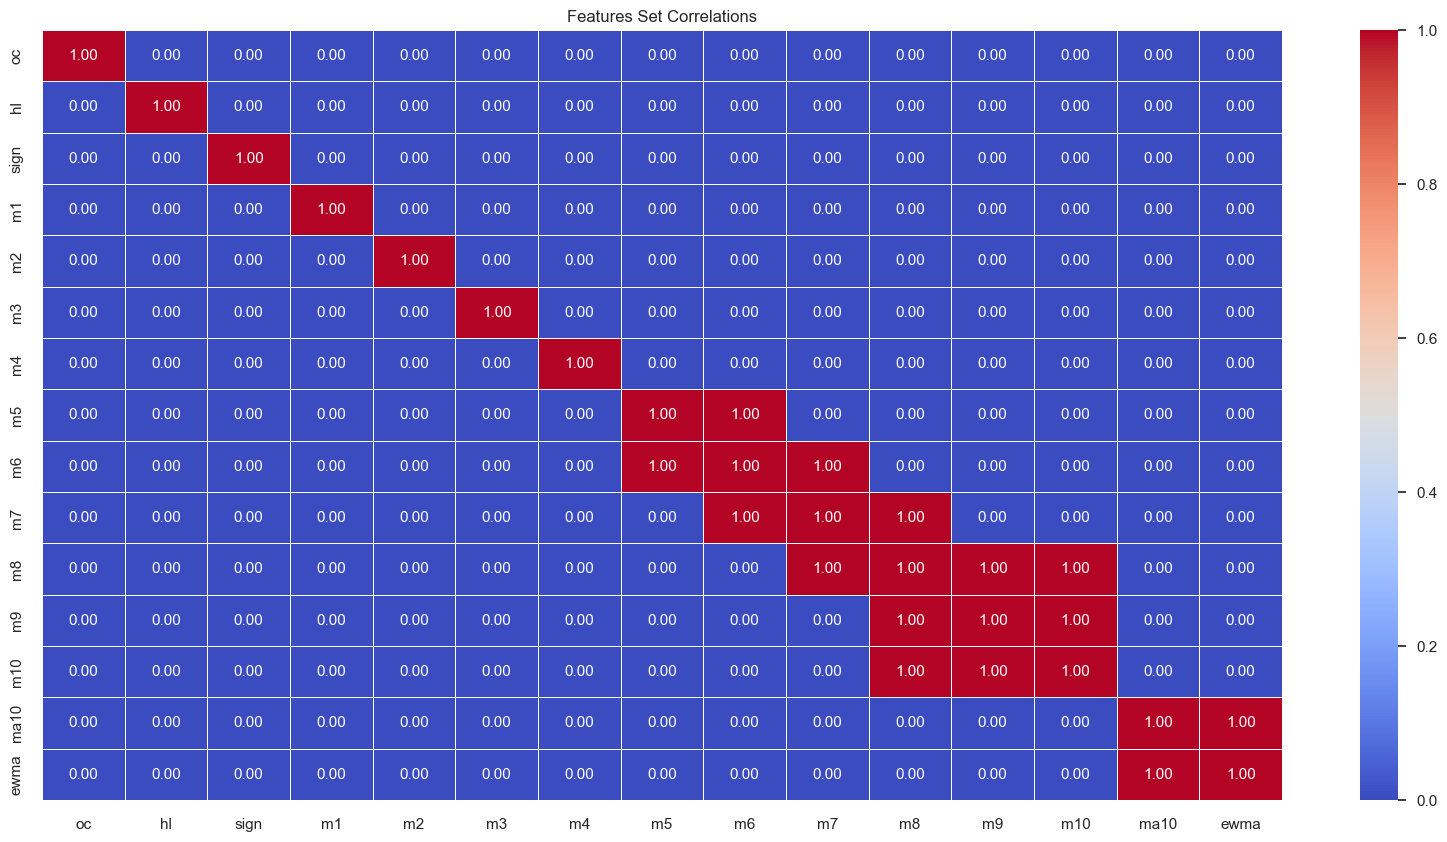

In [72]:
# remove features that are highly correlated
sns.set(rc={'figure.figsize': (20, 10)})

sns.heatmap(df_featured.drop(['open', 'high', 'low', 'close'], axis=1).corr()>0.9, 
            annot=True,  
            annot_kws={"size": 11}, 
            fmt=".2f", 
            linewidth=.5, 
            cmap="coolwarm", 
            cbar=True); #cmap="crest", virids, magma

plt.title('Features Set Correlations');

In [73]:
to_drop = ['m6', 'm7', 'm8', 'm9', 'ewma']
df_featured.drop(to_drop, axis=1, inplace=True)

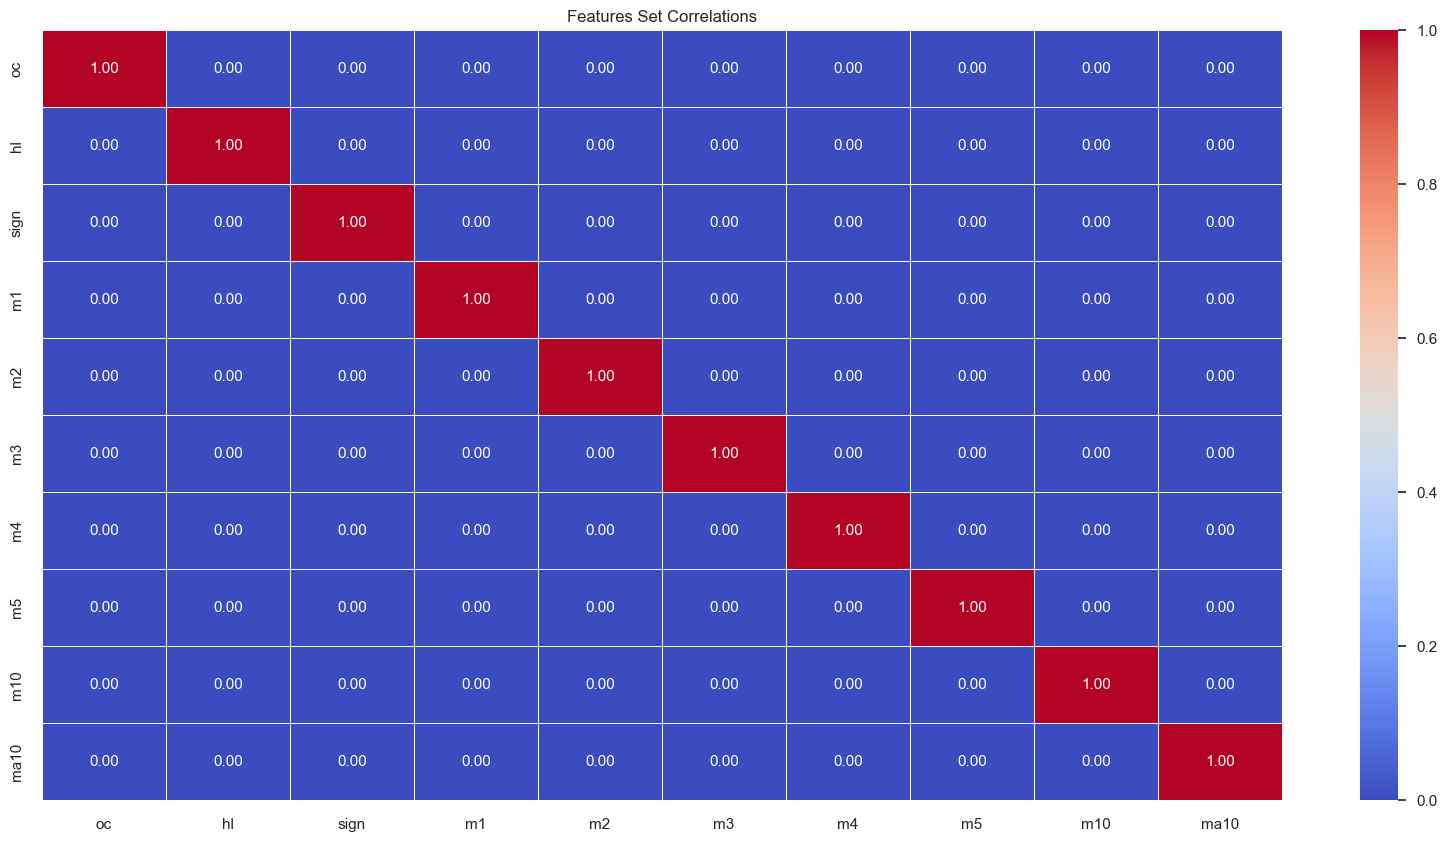

In [74]:
# remove features that are highly correlated
sns.set(rc={'figure.figsize': (20, 10)})

sns.heatmap(df_featured.drop(['open', 'high', 'low', 'close'], axis=1).corr()>0.9, 
            annot=True,  
            annot_kws={"size": 11}, 
            fmt=".2f", 
            linewidth=.5, 
            cmap="coolwarm", 
            cbar=True); #cmap="crest", virids, magma

plt.title('Features Set Correlations');

In [76]:
df_featured.describe()

,open,high,low,close,oc,hl,sign,m1,m2,m3,m4,m5,m10,ma10
count,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000,1230.000000
mean,13.464187,13.678231,13.241037,13.459112,0.005075,0.437194,0.001073,0.015439,0.031230,0.045991,0.061171,0.076598,0.142205,13.391474
std,5.236895,5.339447,5.146613,5.249874,0.311505,0.299531,0.030186,0.381179,0.534827,0.650858,0.757934,0.862433,1.282298,5.185692
min,4.707236,5.179236,4.613687,4.800786,-2.039822,0.087497,-0.352367,-2.883023,-3.929075,-4.609435,-4.350048,-5.396100,-8.260888,5.457758
25%,9.996309,10.172188,9.859260,10.012680,-0.140572,0.232959,-0.012727,-0.144960,-0.217823,-0.252091,-0.276400,-0.271357,-0.384587,9.961719
50%,11.708163,11.885520,11.554111,11.720969,0.004252,0.344439,0.001106,0.013172,0.041760,0.062146,0.089299,0.107995,0.193487,11.709020
75%,16.963984,17.235802,16.674380,16.957445,0.157335,0.544250,0.015818,0.195549,0.284062,0.363005,0.432088,0.501386,0.743815,16.997860
max,28.526247,30.003359,28.440277,29.479727,1.953853,2.149238,0.200671,1.860068,2.243023,2.743209,3.384073,3.399703,4.347846,26.990519


#### Target or Label Definition

Now, we will define dependent variable, and for that we will impose a threshold considering positive returns only the ones above 0.25%, thus:

$$
y_t = 
    \begin{cases}
        1, & \text{if $p_{t+1} > 1.0025 * p_t$}\\ 
        0, & \text{if $p_{t+1}$ otherwise}
    \end{cases}
$$

In [89]:
y = np.where(df_featured.close.shift(-1) / df_featured.close > 1.0025, 1, 0)

In [90]:
X = df_featured[['oc', 'hl']].values

#### Split Data

In [95]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 0)

#### Feature scaling

In [96]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

After performing feature scaling, all values will be normalized and looks like this

In [102]:
pd.DataFrame(data=X_train)

,0,1
0,0.180279,-0.770954
1,-0.298236,-1.059884
2,1.616267,1.821762
3,-0.793814,1.135772
4,0.382914,-0.700072
...,...,...
917,1.434156,0.225632
918,1.820085,0.850007
919,3.064085,2.281022
920,0.088771,-0.814578


In [105]:
classifier = SVC(kernel = 'rbf', random_state=0)
classifier.fit(X_train, y_train)

SVC(random_state=0)

In [106]:
y_pred = classifier.predict(X_test)

In [107]:
pd.DataFrame(data=y_pred)

,0
0,0
1,0
2,0
3,0
4,0
...,...
303,0
304,0
305,0
306,1


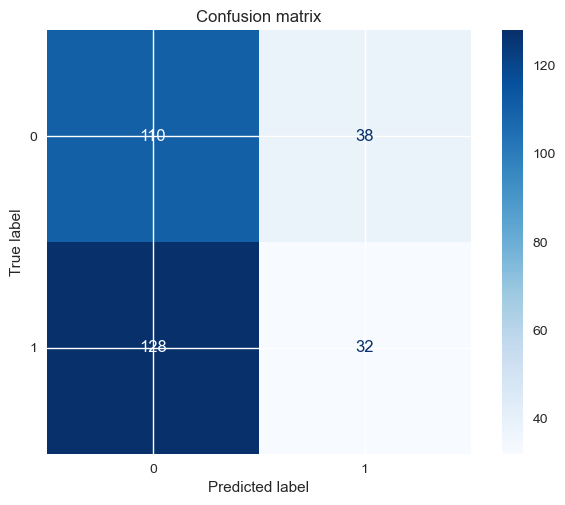

In [112]:
# Display confussion matrix
disp = ConfusionMatrixDisplay.from_estimator(
        classifier,
        X_test,
        y_test,
        display_labels=classifier.classes_,
        cmap=plt.cm.Blues
    )
disp.ax_.set_title('Confusion matrix')
plt.show()

In [115]:
# Classification Report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.46      0.74      0.57       148
           1       0.46      0.20      0.28       160

    accuracy                           0.46       308
   macro avg       0.46      0.47      0.42       308
weighted avg       0.46      0.46      0.42       308



In [116]:
from matplotlib.colors import ListedColormap
X_set, y_set = X_test, y_test
X1, X2 = np.meshgrid(np.arange(start = X_set[:, 0].min() - 1, stop = X_set[:, 0].max() + 1, step = 0.01),
                     np.arange(start = X_set[:, 1].min() - 1, stop = X_set[:, 1].max() + 1, step = 0.01))
plt.contourf(X1, X2, classifier.predict(np.array([X1.ravel(), X2.ravel()]).T).reshape(X1.shape),
             alpha = 0.75, cmap = ListedColormap(('red', 'green')))
plt.xlim(X1.min(), X1.max())
plt.ylim(X2.min(), X2.max())
for i, j in enumerate(np.unique(y_set)):
    plt.scatter(X_set[y_set == j, 0], X_set[y_set == j, 1],
                c = ListedColormap(('red', 'green'))(i), label = j)
plt.title('SVM (Test set)')
plt.xlabel('Age')
plt.ylabel('Estimated Salary')
plt.legend()
plt.show()